In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy
import scipy.stats

In [3]:
seed = 42
rng = np.random.default_rng(seed)

### Non-Markovian Gaussian Sequence Model

- Care: Different naming convention as in robotics book. here $x_t$ are the latent variables. $y_t$ are the measured variables.

- Check: Check how to include external parameteres.

\begin{equation}
 x_t | x_{1:t-1} \sim f_t(\cdot|x_{t-1}), \qquad y_t|x_{1:t} \sim g_t(\cdot|x_{1:t})
\end{equation}

\begin{align}
f_t(x_t|x_{t-1}) &= \mathcal{N}(x_t|\phi x_{t-1}, q) \\
g_t(y_t|x_{1:t}) &= \mathcal{N}(y_t|\sum^{t}_{k=1}\beta^{t-k} x_k, r)
\end{align}

Note that for $\beta = 0$ we have a linear Gaussian SSM.

In [4]:
class inidist:
    
    def __init__(self, q):
        self.q = q
        
    def sample(self, size = 1, rng=None):
        rng = np.random.default_rng(rng)
        return rng.normal(0, np.sqrt(self.q), size=size)


class ft:
    def __init__(self, phi, q):
        self.phi = phi
        self.q =  q
        
    def prob(self, xt, xtm1):
        return scipy.stats.norm.pdf(xt, loc=self.phi * xtm1,
                               scale=np.sqrt(self.q))
    
    def sample(self, xtm1, size = 1, rng=None):
        rng = np.random.default_rng(rng)
        return rng.normal(self.phi * xtm1, np.sqrt(self.q), size=size)
    
class gt:
    def __init__(self, beta, r):
        self.beta = beta
        self.r =  r
        
    def calc_loc(self, xt):
        if isinstance(xt, (list, tuple, np.ndarray)):
            S = (self.beta**(np.flip(np.arange(0, len(xt)))) * xt).sum()
        else:
            S = xt
        return S
        
    def prob(self, yt, xt):
        S = self.calc_loc(xt) 
        return scipy.stats.norm.pdf(yt, loc=S,
                               scale=np.sqrt(self.r))
    
    def sample(self, xt, size = 1, rng=None):
        rng = np.random.default_rng(rng)
        S = self.calc_loc(xt)
        return rng.normal(S, np.sqrt(self.r), size=size)
    

In [5]:
def gaussian_sequence_model(ft, gt, inidist, T, rng = None):
    rng = np.random.default_rng(rng)
    
    xT = np.empty(T)
    yT = np.empty(T)
    
    xT[0] = inidist.sample(q, rng = rng)
    yT[0] = gt.sample(xT[0], rng = rng)
    
    for t in range(1, T):
        xT[t] = ft.sample(xT[t-1], rng = rng)
        yT[t] = gt.sample(xT[:t], rng = rng)
        
    return xT, yT

Create examples of the Non-Markovian Gaussian Sequence Model:

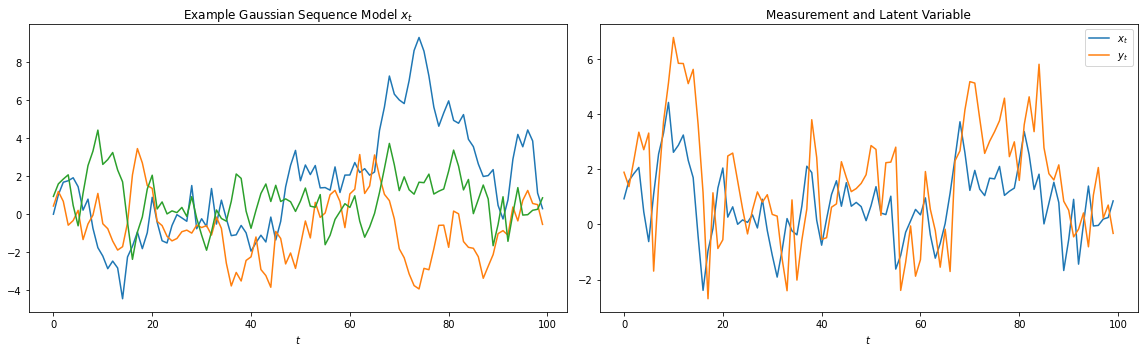

In [25]:
phi, q, beta, r = 0.9, 1, 0.5, 1

ft_m = ft(phi, q)
gt_m = gt(beta, r)
inidist_m = inidist(q)

T = 100
gauss_example, axs = plt.subplots(1, 2, figsize=(16,5))
ax = axs.flatten()
for i in range(3):
    [xt, yt] = gaussian_sequence_model(ft_m, gt_m, inidist_m, T, rng)
    ax[0].plot(xt)
    ax[0].set_title('Example Gaussian Sequence Model $x_t$')
    ax[0].set_xlabel('$t$')

ax[1].plot(xt, label='$x_t$')
ax[1].plot(yt, label='$y_t$')
ax[1].set_xlabel('$t$')
ax[1].legend()
ax[1].set_title('Measurement and Latent Variable')

plt.tight_layout()


In [30]:
def multinomial_resampling(w, x, rng = None):
    rng = np.random.default_rng(rng)
    
    u = rng.random(*w.shape)
    bins = np.cumsum(w)
    
    return x[np.digitize(u, bins)]

def resamp(w, x, M, rng=None):
    rng = np.random.default_rng(rng)
    return x[np.where(rng.multinomial(1, w, size=M) == 1)[1]]

def smc_t(X_tm1, yt, ft, gt, M, rng = None):
    rng = np.random.default_rng(rng)
    chi_t = np.zeros((M, 2))
    X_t = np.zeros(M)
    wt = np.zeros(M)
    
    for m in range(M):
        chi_t[m, 0] = ft.sample(X_tm1[m, -1], rng = rng)
        chi_t[m, 1] = gt.prob(yt, np.append(X_tm1[m, :], X_t[m]))
    
    # Normalize weights --> probabilities
    chi_t[:, 1] /= np.sum(chi_t[:, 1])
        
    return resamp(chi_t[:, 1], chi_t[:, 0], M, rng)

def smc_0(yt, inidist, gt, M, rng=None):
    rng = np.random.default_rng(rng)
    chi_t = np.zeros((M, 2))
    
    for m in range(M):
        chi_t[m, 0] = inidist.sample(size = 1, rng=rng)
        chi_t[m, 1] = gt.prob(yt, chi_t[m, 0])
    
    # Normalize weights --> probabilities
    chi_t[:, 1] /= np.sum(chi_t[:, 1])
    
    return resamp(chi_t[:, 1], chi_t[:, 0], M, rng)


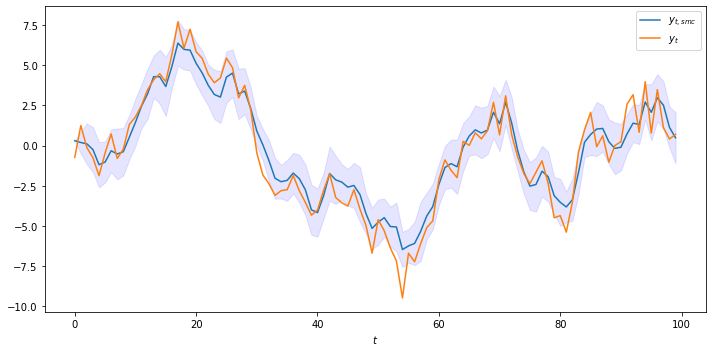

In [35]:
rng = np.random.default_rng(seed)

M = 100
T = 100

phi, q, beta, r = 0.9, 1, 0.5, 1
ft_m = ft(phi, q)
gt_m = gt(beta, r)
inidist_m = inidist(q)

# Generate the model sample
[xT, yT] = gaussian_sequence_model(ft_m, gt_m, inidist_m, T, rng)

rng = np.random.default_rng(seed)
XT_smc = np.zeros((M, T))

# Sample or set initial particle position?
#XT_smc[:, 0] = smc_0(yT[0], inidist_m, gt_m, M, rng=rng)
XT_smc[:, 0] = xT[0]

for t in range(1, T):
    XT_smc[:, t] = smc_t(XT_smc[:, :t], yT[t], ft_m, gt_m, M, rng)
    
    
# 
#xT_smc = np.sum(XT_smc, axis=0) / M
#
Xstd = np.std(XT_smc, axis=0)
Xmean = np.mean(XT_smc, axis=0)

fig, axs = plt.subplots(figsize=(10,5))

axs.plot(Xmean, label='$y_{t, smc}$')
axs.fill_between(np.arange(0, T), Xmean-Xstd, (Xmean+Xstd), color='b', alpha=.1)
axs.plot(yT, label='$y_t$')
axs.set_xlabel('$t$')
axs.legend()

plt.tight_layout()